# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/netifier-2/undersampled.csv', encoding='latin-1')
data.shape

(5798, 5)

In [7]:
data.head()

,processed_text,pornografi,sara,radikalisme,pencemaran_nama_baik
0,sidangahok semoga sipenista agama dan ateknya ...,0,1,1,1
1,itu membuktikan bahwa rakyat malaysia anti cin...,0,1,0,1
2,eh memek diam kamu kepala kamu kaya kontol muk...,1,0,0,0
3,font fira sans some pakistanis dan indian musl...,0,1,1,0
4,pngusiran syiah kok jadi mirip sama di usir ny...,0,0,1,0


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(4638,) (4638, 4)
(1160,) (1160, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [17]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [18]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

In [19]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i, sampling_strategy):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'netifier-undersampled-{sampling_strategy}'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)

        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

## LEAST CONFIDENCE

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5019, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4263, Accuracy: 0.727, F1 Micro: 0.0206, F1 Macro: 0.0217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3797, Accuracy: 0.7773, F1 Micro: 0.394, F1 Macro: 0.3532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3106, Accuracy: 0.8141, F1 Micro: 0.6681, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2771, Accuracy: 0.8292, F1 Micro: 0.6861, F1 Macro: 0.6861
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2456, Accuracy: 0.8376, F1 Micro: 0.7162, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.195, Accuracy: 0.8503, F1 Micro: 0.7366, F1 Macro: 0.741
Epoch 8/10, Train Loss: 0.1526, Accuracy: 0.8557, F1 Micro: 0.7335, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1213, Accuracy: 0.8561, F1 Micro: 0.74, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4526, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3547, Accuracy: 0.7268, F1 Micro: 0.0206, F1 Macro: 0.0215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3004, Accuracy: 0.8053, F1 Micro: 0.6033, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2589, Accuracy: 0.8306, F1 Micro: 0.6806, F1 Macro: 0.6818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.206, Accuracy: 0.8409, F1 Micro: 0.7232, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1784, Accuracy: 0.8546, F1 Micro: 0.7424, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.862, F1 Micro: 0.7432, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.8569, F1 Micro: 0.7603, F1 Macro: 0.7674
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.8657, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.423, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3561, Accuracy: 0.7331, F1 Micro: 0.0742, F1 Macro: 0.0729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3096, Accuracy: 0.8203, F1 Micro: 0.6409, F1 Macro: 0.62
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.8468, F1 Micro: 0.7244, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2075, Accuracy: 0.8678, F1 Micro: 0.7593, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.867, F1 Micro: 0.7554, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.8657, F1 Micro: 0.7781, F1 Macro: 0.7859
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.8701, F1 Micro: 0.7698, F1 Macro: 0.7757
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.8725, F1 Micro: 0.765, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0505, Accuracy: 0.8709,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4406, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3593, Accuracy: 0.7486, F1 Micro: 0.2529, F1 Macro: 0.2304
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3131, Accuracy: 0.8477, F1 Micro: 0.7194, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2435, Accuracy: 0.8645, F1 Micro: 0.7468, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1963, Accuracy: 0.8713, F1 Micro: 0.7747, F1 Macro: 0.7806
Epoch 6/10, Train Loss: 0.15, Accuracy: 0.8742, F1 Micro: 0.7644, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.8734, F1 Micro: 0.7623, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.8705, F1 Micro: 0.7848, F1 Macro: 0.7926
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.8742, F1 Micro: 0.7633, F1 Macro: 0.7616
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4578, Accuracy: 0.7251, F1 Micro: 0.0133, F1 Macro: 0.0118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3623, Accuracy: 0.8154, F1 Micro: 0.5885, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3044, Accuracy: 0.838, F1 Micro: 0.7415, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2478, Accuracy: 0.8752, F1 Micro: 0.7664, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.8779, F1 Micro: 0.7605, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1381, Accuracy: 0.8822, F1 Micro: 0.7973, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.8822, F1 Micro: 0.7982, F1 Macro: 0.8044
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.881, F1 Micro: 0.7788, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.8843, F1 Micro: 0.8036, F1 Macro: 0.8103
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.749, F1 Micro: 0.2128, F1 Macro: 0.1999
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3626, Accuracy: 0.8409, F1 Micro: 0.6877, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2779, Accuracy: 0.8797, F1 Micro: 0.7756, F1 Macro: 0.7803
Epoch 4/10, Train Loss: 0.2345, Accuracy: 0.8781, F1 Micro: 0.7684, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.169, Accuracy: 0.889, F1 Micro: 0.7979, F1 Macro: 0.8014
Epoch 6/10, Train Loss: 0.1184, Accuracy: 0.8859, F1 Micro: 0.7891, F1 Macro: 0.7905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.8843, F1 Micro: 0.7981, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.8832, F1 Micro: 0.7992, F1 Macro: 0.8058
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8867, F1 Micro: 0.7949, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0292, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4537, Accuracy: 0.7718, F1 Micro: 0.3867, F1 Macro: 0.3608
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.361, Accuracy: 0.8602, F1 Micro: 0.7308, F1 Macro: 0.7309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2731, Accuracy: 0.8791, F1 Micro: 0.7757, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2171, Accuracy: 0.8912, F1 Micro: 0.8078, F1 Macro: 0.8123
Epoch 5/10, Train Loss: 0.1624, Accuracy: 0.8906, F1 Micro: 0.8033, F1 Macro: 0.8064
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.8921, F1 Micro: 0.809, F1 Macro: 0.8134
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.8865, F1 Micro: 0.7999, F1 Macro: 0.8035
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.89, F1 Micro: 0.8076, F1 Macro: 0.8121
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.8931, F1 Micro: 0.8052, F1 Macro: 0.8082
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.889, F1 Micro: 0.8089, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4814, Accuracy: 0.787, F1 Micro: 0.4501, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3568, Accuracy: 0.8709, F1 Micro: 0.7528, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2811, Accuracy: 0.8828, F1 Micro: 0.7831, F1 Macro: 0.7833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2175, Accuracy: 0.889, F1 Micro: 0.8105, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.896, F1 Micro: 0.8182, F1 Macro: 0.8226
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.8886, F1 Micro: 0.8123, F1 Macro: 0.8178
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.8921, F1 Micro: 0.8132, F1 Macro: 0.8171
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.8906, F1 Micro: 0.8051, F1 Macro: 0.8098
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.888, F1 Micro: 0.8029, F1 Macro: 0.8072
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.8906, F1 Micro: 0.8077, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4746, Accuracy: 0.8195, F1 Micro: 0.6084, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3398, Accuracy: 0.876, F1 Micro: 0.7761, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2601, Accuracy: 0.8894, F1 Micro: 0.7964, F1 Macro: 0.7999
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.8921, F1 Micro: 0.8087, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.8945, F1 Micro: 0.813, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.8917, F1 Micro: 0.8153, F1 Macro: 0.8203
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8964, F1 Micro: 0.8148, F1 Macro: 0.8178
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.8939, F1 Micro: 0.8124, F1 Macro: 0.8145
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8954, F1 Micro: 0.8181, F1 Macro: 0.8221
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4729, Accuracy: 0.822, F1 Micro: 0.6212, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3205, Accuracy: 0.8816, F1 Micro: 0.7884, F1 Macro: 0.7949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2529, Accuracy: 0.8888, F1 Micro: 0.7973, F1 Macro: 0.8008
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.8931, F1 Micro: 0.7977, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.8984, F1 Micro: 0.8144, F1 Macro: 0.8168
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.8956, F1 Micro: 0.8113, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.897, F1 Micro: 0.8191, F1 Macro: 0.8227
Epoch 8/10, Train Loss: 0.0563, Accuracy: 0.8939, F1 Micro: 0.8173, F1 Macro: 0.8216
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.896, F1 Micro: 0.8193, F1 Macro: 0.8232
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8343, F1 Micro: 0.6449, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3099, Accuracy: 0.8845, F1 Micro: 0.7861, F1 Macro: 0.7906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2361, Accuracy: 0.8919, F1 Micro: 0.8108, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.8937, F1 Micro: 0.8123, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.8958, F1 Micro: 0.815, F1 Macro: 0.8187
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.8978, F1 Micro: 0.8184, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.8956, F1 Micro: 0.8197, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0473, Accuracy: 0.8972, F1 Micro: 0.8233, F1 Macro: 0.8274
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.897, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8507, F1 Micro: 0.7135, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3025, Accuracy: 0.884, F1 Micro: 0.79, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2277, Accuracy: 0.8884, F1 Micro: 0.7911, F1 Macro: 0.7911
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.8941, F1 Micro: 0.8046, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.8927, F1 Micro: 0.8154, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.8954, F1 Micro: 0.8193, F1 Macro: 0.8254
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.8896, F1 Micro: 0.8079, F1 Macro: 0.8094
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.8935, F1 Micro: 0.8073, F1 Macro: 0.8084
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.8919, F1 Micro: 0.8161, F1 Macro: 0.82
Epoch 10/10, Train Loss: 0.0299, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8596, F1 Micro: 0.7216, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2931, Accuracy: 0.8865, F1 Micro: 0.7912, F1 Macro: 0.7934
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.8898, F1 Micro: 0.8118, F1 Macro: 0.8169
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.8988, F1 Micro: 0.8095, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.8976, F1 Micro: 0.8139, F1 Macro: 0.8184
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.8902, F1 Micro: 0.8161, F1 Macro: 0.8224
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.8976, F1 Micro: 0.822, F1 Macro: 0.8259
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9001, F1 Micro: 0.8215, F1 Macro: 0.8245
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9005, F1 Micro: 0.8243, F1 Macro: 0.8278
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4561, Accuracy: 0.8651, F1 Micro: 0.7496, F1 Macro: 0.7524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.8836, F1 Micro: 0.7943, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.8923, F1 Micro: 0.8085, F1 Macro: 0.8107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.8966, F1 Micro: 0.8209, F1 Macro: 0.826
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.8949, F1 Micro: 0.8159, F1 Macro: 0.821
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.8968, F1 Micro: 0.8169, F1 Macro: 0.8206
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.8962, F1 Micro: 0.817, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.8966, F1 Micro: 0.8213, F1 Macro: 0.8258
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.8988, F1 Micro: 0.8193, F1 Macro: 0.822
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8937, F1 Micro: 0.8192, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.427, Accuracy: 0.8631, F1 Micro: 0.7297, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.881, F1 Micro: 0.7622, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.8964, F1 Micro: 0.8196, F1 Macro: 0.8245
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.897, F1 Micro: 0.8147, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.8982, F1 Micro: 0.8207, F1 Macro: 0.8245
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.8991, F1 Micro: 0.8257, F1 Macro: 0.8301
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8997, F1 Micro: 0.8183, F1 Macro: 0.8209
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.897, F1 Micro: 0.8181, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9003, F1 Micro: 0.8261, F1 Macro: 0.829
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4285, Accuracy: 0.8736, F1 Micro: 0.763, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.8914, F1 Micro: 0.8042, F1 Macro: 0.8089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.8993, F1 Micro: 0.8143, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.8999, F1 Micro: 0.8227, F1 Macro: 0.8266
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.8945, F1 Micro: 0.8127, F1 Macro: 0.8152
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.8984, F1 Micro: 0.8201, F1 Macro: 0.824
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.8966, F1 Micro: 0.8194, F1 Macro: 0.8225
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.8986, F1 Micro: 0.8203, F1 Macro: 0.8251
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.8999, F1 Micro: 0.8268, F1 Macro: 0.8309
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9013, F1 Micro: 0.8234, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8697, F1 Micro: 0.7537, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8834, F1 Micro: 0.8004, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.8935, F1 Micro: 0.8122, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.898, F1 Micro: 0.8138, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.898, F1 Micro: 0.8167, F1 Macro: 0.8198
Epoch 6/10, Train Loss: 0.0812, Accuracy: 0.8943, F1 Micro: 0.8095, F1 Macro: 0.8122
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.8986, F1 Micro: 0.8167, F1 Macro: 0.8206
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.898, F1 Micro: 0.8152, F1 Macro: 0.8187
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9005, F1 Micro: 0.8276, F1 Macro: 0.832
Epoch 10/10, Train Loss: 0.0264, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8795, F1 Micro: 0.7805, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.8886, F1 Micro: 0.8059, F1 Macro: 0.8109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.897, F1 Micro: 0.814, F1 Macro: 0.8176
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.8949, F1 Micro: 0.8132, F1 Macro: 0.8184
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.8947, F1 Micro: 0.814, F1 Macro: 0.8164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0815, Accuracy: 0.9003, F1 Micro: 0.8212, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.8999, F1 Micro: 0.8234, F1 Macro: 0.8271
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.8951, F1 Micro: 0.8186, F1 Macro: 0.8234
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9001, F1 Micro: 0.8224, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0283, Accuracy: 

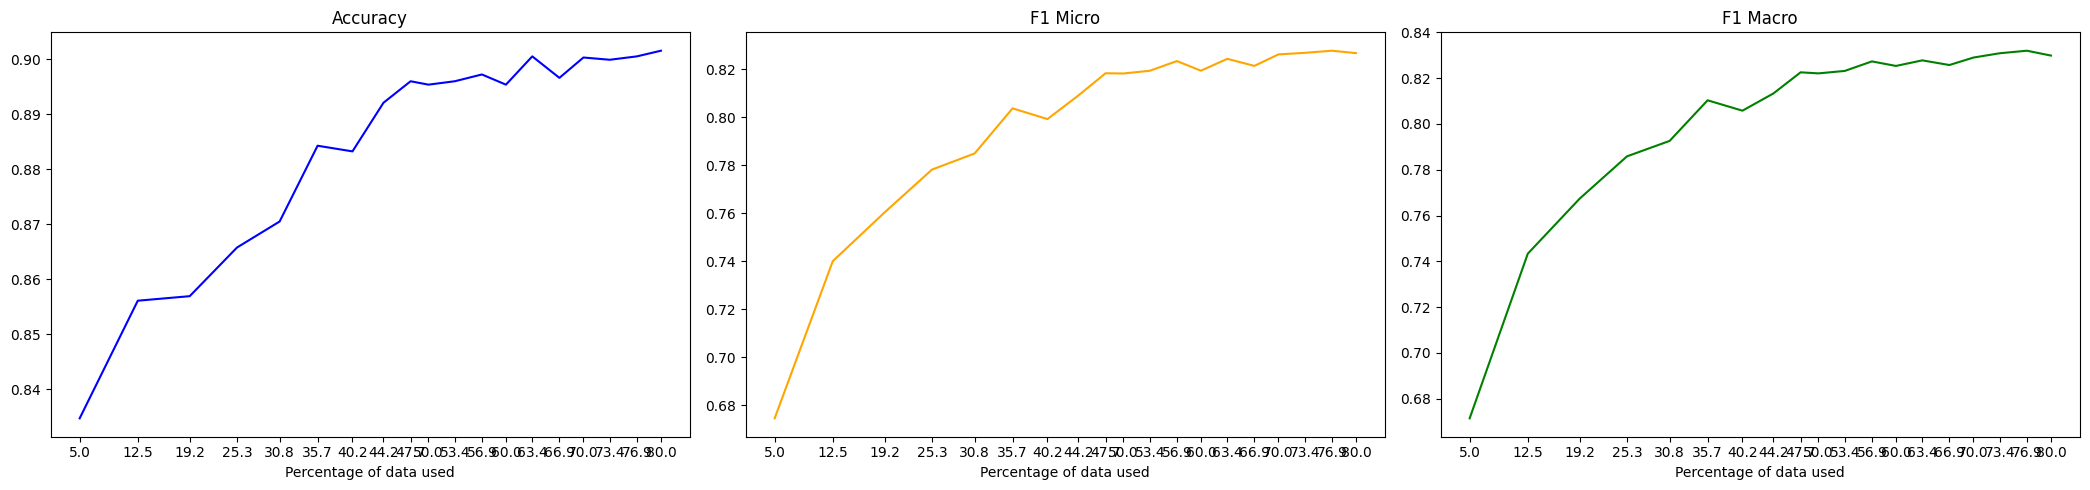

In [22]:
active_learning(42, 0, 'lc')

# MONTE CARLO DROPOUT

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6233, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5677, Accuracy: 0.7447, F1 Micro: 0.2159, F1 Macro: 0.179
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5116, Accuracy: 0.8224, F1 Micro: 0.6444, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4118, Accuracy: 0.8487, F1 Micro: 0.7241, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3384, Accuracy: 0.8586, F1 Micro: 0.736, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2832, Accuracy: 0.8633, F1 Micro: 0.7497, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2194, Accuracy: 0.8744, F1 Micro: 0.7745, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.1728, Accuracy: 0.8686, F1 Micro: 0.7387, F1 Macro: 0.7327
Epoch 9/10, Train Loss: 0.1403, Accuracy: 0.8682, F1 Micro: 0.7573, F1 Macro: 0.7583
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6071, Accuracy: 0.7286, F1 Micro: 0.0421, F1 Macro: 0.0393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5184, Accuracy: 0.8265, F1 Micro: 0.6236, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4304, Accuracy: 0.8524, F1 Micro: 0.7274, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3615, Accuracy: 0.8678, F1 Micro: 0.7683, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2807, Accuracy: 0.8808, F1 Micro: 0.7722, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.2387, Accuracy: 0.8773, F1 Micro: 0.7685, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.191, Accuracy: 0.8801, F1 Micro: 0.7794, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1352, Accuracy: 0.8801, F1 Micro: 0.7865, F1 Macro: 0.7879
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1063, Accuracy: 0.8845, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.594, Accuracy: 0.7467, F1 Micro: 0.3447, F1 Macro: 0.3096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5009, Accuracy: 0.8501, F1 Micro: 0.7038, F1 Macro: 0.7029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8697, F1 Micro: 0.7488, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3412, Accuracy: 0.8787, F1 Micro: 0.7784, F1 Macro: 0.7827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2635, Accuracy: 0.8834, F1 Micro: 0.7899, F1 Macro: 0.7922
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2156, Accuracy: 0.8871, F1 Micro: 0.7994, F1 Macro: 0.8025
Epoch 7/10, Train Loss: 0.1789, Accuracy: 0.8888, F1 Micro: 0.7988, F1 Macro: 0.8005
Epoch 8/10, Train Loss: 0.1424, Accuracy: 0.8865, F1 Micro: 0.7949, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.098, Accuracy: 0.8894, F1 Micro: 0.8051, F1 Macro: 0.8074
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5914, Accuracy: 0.7529, F1 Micro: 0.3337, F1 Macro: 0.252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4787, Accuracy: 0.8477, F1 Micro: 0.6972, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3876, Accuracy: 0.8764, F1 Micro: 0.7738, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3099, Accuracy: 0.888, F1 Micro: 0.8017, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2585, Accuracy: 0.8925, F1 Micro: 0.8058, F1 Macro: 0.8101
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2009, Accuracy: 0.8933, F1 Micro: 0.8136, F1 Macro: 0.8181
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1575, Accuracy: 0.8943, F1 Micro: 0.8155, F1 Macro: 0.8182
Epoch 8/10, Train Loss: 0.1138, Accuracy: 0.8939, F1 Micro: 0.8092, F1 Macro: 0.8108
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.8904, F1 Micro: 0.8067, F1 Macro: 0.8108
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5711, Accuracy: 0.7601, F1 Micro: 0.475, F1 Macro: 0.3617
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4485, Accuracy: 0.8633, F1 Micro: 0.7443, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3607, Accuracy: 0.8777, F1 Micro: 0.7906, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2927, Accuracy: 0.8921, F1 Micro: 0.8051, F1 Macro: 0.8097
Epoch 5/10, Train Loss: 0.2419, Accuracy: 0.8919, F1 Micro: 0.8008, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.8917, F1 Micro: 0.8086, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1345, Accuracy: 0.8927, F1 Micro: 0.8116, F1 Macro: 0.8159
Epoch 8/10, Train Loss: 0.1013, Accuracy: 0.8892, F1 Micro: 0.8076, F1 Macro: 0.8119
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.8958, F1 Micro: 0.8089, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5644, Accuracy: 0.7995, F1 Micro: 0.5053, F1 Macro: 0.45
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.433, Accuracy: 0.8713, F1 Micro: 0.7692, F1 Macro: 0.7739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3519, Accuracy: 0.8847, F1 Micro: 0.7911, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2918, Accuracy: 0.8947, F1 Micro: 0.8087, F1 Macro: 0.8129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2341, Accuracy: 0.8972, F1 Micro: 0.8186, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1761, Accuracy: 0.8956, F1 Micro: 0.8213, F1 Macro: 0.8252
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.8935, F1 Micro: 0.8134, F1 Macro: 0.8182
Epoch 8/10, Train Loss: 0.09, Accuracy: 0.8941, F1 Micro: 0.8114, F1 Macro: 0.8139
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.8972, F1 Micro: 0.8148, F1 Macro: 0.8182
Epoch 10/10, Train Loss: 0.0569, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.8314, F1 Micro: 0.6511, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4035, Accuracy: 0.8758, F1 Micro: 0.776, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3396, Accuracy: 0.8906, F1 Micro: 0.8067, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.272, Accuracy: 0.8919, F1 Micro: 0.814, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2262, Accuracy: 0.8954, F1 Micro: 0.8183, F1 Macro: 0.8219
Epoch 6/10, Train Loss: 0.1667, Accuracy: 0.8968, F1 Micro: 0.818, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.8982, F1 Micro: 0.8187, F1 Macro: 0.8226
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.898, F1 Micro: 0.8184, F1 Macro: 0.8211
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.8974, F1 Micro: 0.8181, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5399, Accuracy: 0.8292, F1 Micro: 0.6258, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.394, Accuracy: 0.8758, F1 Micro: 0.7763, F1 Macro: 0.7832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3102, Accuracy: 0.8914, F1 Micro: 0.8031, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2517, Accuracy: 0.8931, F1 Micro: 0.8095, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1962, Accuracy: 0.8956, F1 Micro: 0.8146, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1546, Accuracy: 0.8984, F1 Micro: 0.818, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.8972, F1 Micro: 0.8184, F1 Macro: 0.8236
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.8976, F1 Micro: 0.8146, F1 Macro: 0.8159
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.8976, F1 Micro: 0.8133, F1 Macro: 0.8161
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5387, Accuracy: 0.8152, F1 Micro: 0.614, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3839, Accuracy: 0.8832, F1 Micro: 0.7927, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3096, Accuracy: 0.8896, F1 Micro: 0.8054, F1 Macro: 0.8092
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2592, Accuracy: 0.8972, F1 Micro: 0.8072, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2005, Accuracy: 0.8943, F1 Micro: 0.8151, F1 Macro: 0.8174
Epoch 6/10, Train Loss: 0.1428, Accuracy: 0.8972, F1 Micro: 0.8151, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.8997, F1 Micro: 0.8197, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.8947, F1 Micro: 0.8206, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9001, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5331, Accuracy: 0.8316, F1 Micro: 0.6299, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3737, Accuracy: 0.8795, F1 Micro: 0.7907, F1 Macro: 0.7965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2996, Accuracy: 0.8945, F1 Micro: 0.8017, F1 Macro: 0.8042
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.898, F1 Micro: 0.8188, F1 Macro: 0.8225
Epoch 5/10, Train Loss: 0.1893, Accuracy: 0.8993, F1 Micro: 0.8178, F1 Macro: 0.8216
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.8976, F1 Micro: 0.8131, F1 Macro: 0.8164
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.8986, F1 Micro: 0.8203, F1 Macro: 0.8241
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.8964, F1 Micro: 0.8203, F1 Macro: 0.8243
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.8984, F1 Micro: 0.82, F1 Macro: 0.8236
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0418, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5031, Accuracy: 0.8612, F1 Micro: 0.7423, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3514, Accuracy: 0.8847, F1 Micro: 0.792, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2775, Accuracy: 0.8927, F1 Micro: 0.8103, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2304, Accuracy: 0.8939, F1 Micro: 0.8139, F1 Macro: 0.8178
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.896, F1 Micro: 0.8182, F1 Macro: 0.8226
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.8956, F1 Micro: 0.8131, F1 Macro: 0.8167
Epoch 7/10, Train Loss: 0.0971, Accuracy: 0.8964, F1 Micro: 0.8137, F1 Macro: 0.8166
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.8999, F1 Micro: 0.819, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.8993, F1 Micro: 0.8197, F1 Macro: 0.8233
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.496, Accuracy: 0.8651, F1 Micro: 0.7479, F1 Macro: 0.7451
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.888, F1 Micro: 0.8026, F1 Macro: 0.8074
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2782, Accuracy: 0.8949, F1 Micro: 0.8028, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2112, Accuracy: 0.8937, F1 Micro: 0.81, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.8972, F1 Micro: 0.8125, F1 Macro: 0.8165
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.8933, F1 Micro: 0.812, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.8993, F1 Micro: 0.818, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.8997, F1 Micro: 0.8224, F1 Macro: 0.8254
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9011, F1 Micro: 0.82

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4903, Accuracy: 0.8637, F1 Micro: 0.7645, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3272, Accuracy: 0.8869, F1 Micro: 0.7978, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2545, Accuracy: 0.8931, F1 Micro: 0.814, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2035, Accuracy: 0.9013, F1 Micro: 0.8247, F1 Macro: 0.8302
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.8968, F1 Micro: 0.8181, F1 Macro: 0.8225
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.8974, F1 Micro: 0.8193, F1 Macro: 0.8235
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.8993, F1 Micro: 0.8241, F1 Macro: 0.8277
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9003, F1 Micro: 0.8218, F1 Macro: 0.8254
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.8993, F1 Micro: 0.8172, F1 Macro: 0.8192
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.8988, F1 Micro: 0.8198, F1 Macro: 0.8228

 Iteration 3678: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.8662, F1 Micro: 0.7747, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2989, Accuracy: 0.8906, F1 Micro: 0.8003, F1 Macro: 0.8032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.9009, F1 Micro: 0.8149, F1 Macro: 0.8177
Epoch 4/10, Train Loss: 0.1917, Accuracy: 0.8954, F1 Micro: 0.804, F1 Macro: 0.805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1484, Accuracy: 0.8974, F1 Micro: 0.8166, F1 Macro: 0.8192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.8999, F1 Micro: 0.8173, F1 Macro: 0.8191
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.8949, F1 Micro: 0.8163, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.898, F1 Micro: 0.823, F1 Macro: 0.827
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.898, F1 Micro: 0.8191, F1 Macro: 0.8218
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4524, Accuracy: 0.8653, F1 Micro: 0.7299, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.889, F1 Micro: 0.8009, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2315, Accuracy: 0.8956, F1 Micro: 0.8146, F1 Macro: 0.8177
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.8968, F1 Micro: 0.8121, F1 Macro: 0.8146
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.8972, F1 Micro: 0.817, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8931, F1 Micro: 0.8191, F1 Macro: 0.8238
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.8943, F1 Micro: 0.8164, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9003, F1 Micro: 0.8229, F1 Macro: 0.8258
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9019, F1 Micro: 0.8199, F1 Macro: 0.8225
Epoch 10/10, Train Loss: 0.0314, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8715, F1 Micro: 0.7759, F1 Macro: 0.7824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.8888, F1 Micro: 0.8063, F1 Macro: 0.812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.8995, F1 Micro: 0.8195, F1 Macro: 0.8223
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.8997, F1 Micro: 0.8179, F1 Macro: 0.8206
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.8972, F1 Micro: 0.8192, F1 Macro: 0.8234
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.897, F1 Micro: 0.8155, F1 Macro: 0.8177
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8886, F1 Micro: 0.8122, F1 Macro: 0.8178
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.8984, F1 Micro: 0.8208, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.035, Accuracy: 0.8991, F1 Micro: 0.8209, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0308, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.427, Accuracy: 0.8756, F1 Micro: 0.775, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2631, Accuracy: 0.8877, F1 Micro: 0.8022, F1 Macro: 0.8061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.8933, F1 Micro: 0.8168, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.8978, F1 Micro: 0.8173, F1 Macro: 0.8216
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9015, F1 Micro: 0.8189, F1 Macro: 0.822
Epoch 6/10, Train Loss: 0.0872, Accuracy: 0.9021, F1 Micro: 0.8172, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9019, F1 Micro: 0.8199, F1 Macro: 0.8229
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8976, F1 Micro: 0.8168, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.8964, F1 Micro: 0.8227, F1 Macro: 0.8279
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8729, F1 Micro: 0.7769, F1 Macro: 0.7833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.8951, F1 Micro: 0.8064, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.896, F1 Micro: 0.8173, F1 Macro: 0.8226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.8982, F1 Micro: 0.8258, F1 Macro: 0.8307
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9003, F1 Micro: 0.8172, F1 Macro: 0.8182
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.8956, F1 Micro: 0.8196, F1 Macro: 0.8251
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9001, F1 Micro: 0.8217, F1 Macro: 0.8255
Epoch 8/10, Train Loss: 0.0414, Accuracy: 0.8999, F1 Micro: 0.8142, F1 Macro: 0.8166
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.8999, F1 Micro: 0.8221, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9025, F1 Micro: 0.8262, F1 

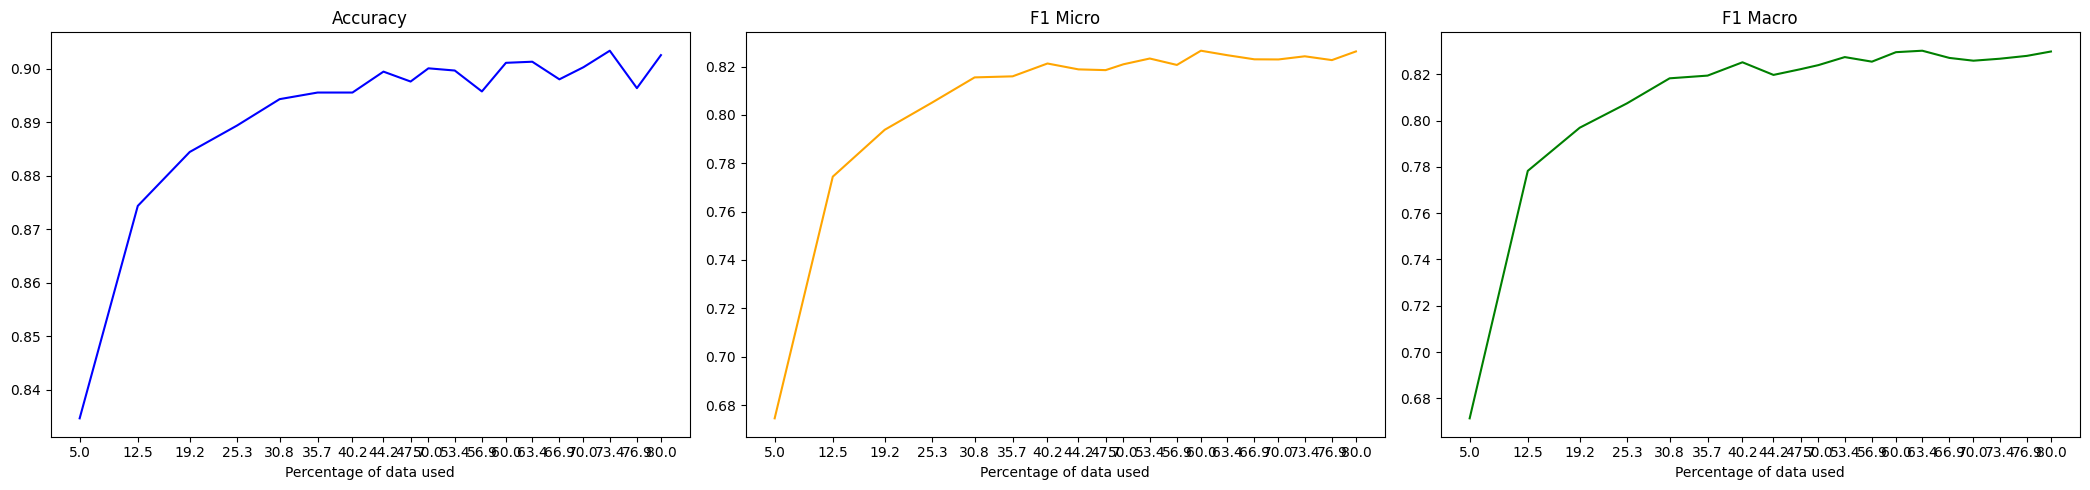

In [23]:
active_learning(42, 0, 'mc')

# KMEANS

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.581, Accuracy: 0.7284, F1 Micro: 0.0308, F1 Macro: 0.0319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4692, Accuracy: 0.786, F1 Micro: 0.4327, F1 Macro: 0.3947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3887, Accuracy: 0.817, F1 Micro: 0.6041, F1 Macro: 0.5733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3271, Accuracy: 0.831, F1 Micro: 0.6584, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.276, Accuracy: 0.8499, F1 Micro: 0.7082, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2342, Accuracy: 0.859, F1 Micro: 0.7324, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1895, Accuracy: 0.8629, F1 Micro: 0.7503, F1 Macro: 0.7541
Epoch 8/10, Train Loss: 0.1407, Accuracy: 0.8694, F1 Micro: 0.7471, F1 Macro: 0.7492
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1201, Accuracy: 0.8688, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.551, Accuracy: 0.7656, F1 Micro: 0.2683, F1 Macro: 0.2215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.8129, F1 Micro: 0.5633, F1 Macro: 0.5286
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3353, Accuracy: 0.8464, F1 Micro: 0.7092, F1 Macro: 0.7102
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.263, Accuracy: 0.8588, F1 Micro: 0.7266, F1 Macro: 0.7241
Epoch 5/10, Train Loss: 0.2179, Accuracy: 0.8565, F1 Micro: 0.7101, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1751, Accuracy: 0.867, F1 Micro: 0.7356, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1509, Accuracy: 0.869, F1 Micro: 0.7451, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.8721, F1 Micro: 0.7524, F1 Macro: 0.7526
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.8697, F1 Micro: 0.7484, F1 Macro: 0.7488
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5422, Accuracy: 0.78, F1 Micro: 0.3975, F1 Macro: 0.3313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3847, Accuracy: 0.8277, F1 Micro: 0.6308, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3111, Accuracy: 0.8551, F1 Micro: 0.6988, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2461, Accuracy: 0.875, F1 Micro: 0.7634, F1 Macro: 0.7665
Epoch 5/10, Train Loss: 0.2001, Accuracy: 0.8752, F1 Micro: 0.7581, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1571, Accuracy: 0.8849, F1 Micro: 0.7811, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.1243, Accuracy: 0.8773, F1 Micro: 0.7665, F1 Macro: 0.7662
Epoch 8/10, Train Loss: 0.092, Accuracy: 0.8783, F1 Micro: 0.7781, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.8711, F1 Micro: 0.7513, F1 Macro: 0.7481
Epoch 10/10, Train Loss: 0.0584, Accuracy: 0.8771, F1 Micro: 0.7587, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.514, Accuracy: 0.8039, F1 Micro: 0.5538, F1 Macro: 0.4972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3621, Accuracy: 0.8507, F1 Micro: 0.7044, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.285, Accuracy: 0.8791, F1 Micro: 0.7705, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2158, Accuracy: 0.8808, F1 Micro: 0.7837, F1 Macro: 0.7883
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.8849, F1 Micro: 0.779, F1 Macro: 0.7802
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.8849, F1 Micro: 0.7816, F1 Macro: 0.7837
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.8799, F1 Micro: 0.7791, F1 Macro: 0.7825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.8779, F1 Micro: 0.7846, F1 Macro: 0.7906
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.8834, F1 Micro: 0.7845, F1 Macro: 0.7874
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.8801, F1 Micro: 0.7811, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4996, Accuracy: 0.8121, F1 Micro: 0.5823, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.341, Accuracy: 0.8651, F1 Micro: 0.7572, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2656, Accuracy: 0.8812, F1 Micro: 0.7724, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.215, Accuracy: 0.8859, F1 Micro: 0.7906, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1557, Accuracy: 0.8884, F1 Micro: 0.7993, F1 Macro: 0.8048
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.882, F1 Micro: 0.7946, F1 Macro: 0.7997
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.8863, F1 Micro: 0.792, F1 Macro: 0.7948
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.8859, F1 Micro: 0.791, F1 Macro: 0.7938
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.8863, F1 Micro: 0.7942, F1 Macro: 0.7975
Epoch 10/10, Train Loss: 0.0383, Accuracy: 0.8884, F1 Micro: 0.7871, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4991, Accuracy: 0.8106, F1 Micro: 0.5793, F1 Macro: 0.5237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3299, Accuracy: 0.868, F1 Micro: 0.7592, F1 Macro: 0.7623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2574, Accuracy: 0.8838, F1 Micro: 0.7849, F1 Macro: 0.7882
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.8836, F1 Micro: 0.7701, F1 Macro: 0.7702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1583, Accuracy: 0.8863, F1 Micro: 0.8033, F1 Macro: 0.8098
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.884, F1 Micro: 0.8027, F1 Macro: 0.8085
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.8867, F1 Micro: 0.7835, F1 Macro: 0.7856
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.8877, F1 Micro: 0.7905, F1 Macro: 0.7921
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.8875, F1 Micro: 0.7866, F1 Macro: 0.7888
Epoch 10/10, Train Loss: 0.0365, Accuracy: 0.8826, F1 Micro: 0.7959, F1 Macro: 0.8002

 Iteration 2329: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4748, Accuracy: 0.8306, F1 Micro: 0.6529, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.8676, F1 Micro: 0.7301, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2365, Accuracy: 0.8843, F1 Micro: 0.7919, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.891, F1 Micro: 0.8057, F1 Macro: 0.8113
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.883, F1 Micro: 0.7708, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.8834, F1 Micro: 0.8044, F1 Macro: 0.8119
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.8882, F1 Micro: 0.8004, F1 Macro: 0.8058
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.8912, F1 Micro: 0.8041, F1 Macro: 0.8081
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.888, F1 Micro: 0.7864, F1 Macro: 0.7881
Epoch 10/10, Train Loss: 0.0377, Accuracy: 0.8871, F1 Micro: 0.7978, F1 Macro: 0.8023

 Iteration 2560: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4789, Accuracy: 0.8065, F1 Micro: 0.533, F1 Macro: 0.4811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3033, Accuracy: 0.8725, F1 Micro: 0.7608, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.8886, F1 Micro: 0.7866, F1 Macro: 0.7856
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.8941, F1 Micro: 0.8041, F1 Macro: 0.8066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1418, Accuracy: 0.8925, F1 Micro: 0.8108, F1 Macro: 0.8155
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.8937, F1 Micro: 0.8089, F1 Macro: 0.8122
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.8945, F1 Micro: 0.8122, F1 Macro: 0.8162
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.8939, F1 Micro: 0.8086, F1 Macro: 0.8117
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.896, F1 Micro: 0.8095, F1 Macro: 0.8117
Epoch 10/10, Train Loss: 0.0328, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4734, Accuracy: 0.8218, F1 Micro: 0.605, F1 Macro: 0.5804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3122, Accuracy: 0.8771, F1 Micro: 0.7602, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2281, Accuracy: 0.8912, F1 Micro: 0.8003, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.884, F1 Micro: 0.8083, F1 Macro: 0.8176
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.8912, F1 Micro: 0.8062, F1 Macro: 0.8108
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.8921, F1 Micro: 0.8063, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.8943, F1 Micro: 0.8089, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.8929, F1 Micro: 0.8124, F1 Macro: 0.8171
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.8956, F1 Micro: 0.8036, F1 Macro: 0.803
Epoch 10/10, Train Loss: 0.0359, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.46, Accuracy: 0.8456, F1 Micro: 0.6916, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2863, Accuracy: 0.8849, F1 Micro: 0.7853, F1 Macro: 0.7876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.8826, F1 Micro: 0.7856, F1 Macro: 0.7872
Epoch 4/10, Train Loss: 0.1841, Accuracy: 0.8902, F1 Micro: 0.7842, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.8947, F1 Micro: 0.808, F1 Macro: 0.8122
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.8949, F1 Micro: 0.8003, F1 Macro: 0.8031
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8939, F1 Micro: 0.8048, F1 Macro: 0.8081
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.8945, F1 Micro: 0.8072, F1 Macro: 0.8094
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.8927, F1 Micro: 0.8079, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.8923, F1 Micro: 0.8106, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.8374, F1 Micro: 0.6571, F1 Macro: 0.6315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.8801, F1 Micro: 0.7809, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.891, F1 Micro: 0.803, F1 Macro: 0.8068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1748, Accuracy: 0.8951, F1 Micro: 0.8124, F1 Macro: 0.8163
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.8923, F1 Micro: 0.8097, F1 Macro: 0.8123
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.8941, F1 Micro: 0.8099, F1 Macro: 0.8138
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.897, F1 Micro: 0.8119, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.8937, F1 Micro: 0.8156, F1 Macro: 0.8211
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.8921, F1 Micro: 0.8185, F1 Macro: 0.8245
Epoch 10/10, Train Loss: 0.0316, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4474, Accuracy: 0.8472, F1 Micro: 0.6793, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.8921, F1 Micro: 0.8053, F1 Macro: 0.8104
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.8896, F1 Micro: 0.8133, F1 Macro: 0.8193
Epoch 4/10, Train Loss: 0.1638, Accuracy: 0.8943, F1 Micro: 0.8011, F1 Macro: 0.8039
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.8865, F1 Micro: 0.8095, F1 Macro: 0.8155
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.8919, F1 Micro: 0.8059, F1 Macro: 0.8119
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0659, Accuracy: 0.8951, F1 Micro: 0.8143, F1 Macro: 0.8182
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.8941, F1 Micro: 0.811, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.8988, F1 Micro: 0.8148, F1 Macro: 0.8172
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.897, F1 Micro: 0.8116, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4529, Accuracy: 0.8682, F1 Micro: 0.7598, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.8898, F1 Micro: 0.797, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.8988, F1 Micro: 0.8182, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.898, F1 Micro: 0.8212, F1 Macro: 0.8259
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9001, F1 Micro: 0.8149, F1 Macro: 0.8187
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.8993, F1 Micro: 0.821, F1 Macro: 0.8252
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.8993, F1 Micro: 0.8118, F1 Macro: 0.8138
Epoch 8/10, Train Loss: 0.045, Accuracy: 0.9021, F1 Micro: 0.8183, F1 Macro: 0.8184
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.8949, F1 Micro: 0.8186, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9003, F1 Micro: 0.8231, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.868, F1 Micro: 0.7527, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.8923, F1 Micro: 0.8003, F1 Macro: 0.8021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.8939, F1 Micro: 0.8165, F1 Macro: 0.8218
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.8974, F1 Micro: 0.8112, F1 Macro: 0.814
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.8974, F1 Micro: 0.8159, F1 Macro: 0.8211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9028, F1 Micro: 0.8242, F1 Macro: 0.8279
Epoch 7/10, Train Loss: 0.0667, Accuracy: 0.8968, F1 Micro: 0.8141, F1 Macro: 0.817
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.8976, F1 Micro: 0.8115, F1 Macro: 0.8125
Epoch 9/10, Train Loss: 0.0351, Accuracy: 0.9001, F1 Micro: 0.824, F1 Macro: 0.8273
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9001, F1 Micro: 0.8205, F1 Macro: 0.8242

 Iteration 3878: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4416, Accuracy: 0.8713, F1 Micro: 0.7609, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.888, F1 Micro: 0.7981, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.896, F1 Micro: 0.8091, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9011, F1 Micro: 0.8172, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.8966, F1 Micro: 0.819, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9001, F1 Micro: 0.8235, F1 Macro: 0.8273
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9007, F1 Micro: 0.8257, F1 Macro: 0.8292
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.8978, F1 Micro: 0.8076, F1 Macro: 0.8082
Epoch 9/10, Train Loss: 0.0393, Accuracy: 0.8995, F1 Micro: 0.8247, F1 Macro: 0.8292
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4286, Accuracy: 0.8731, F1 Micro: 0.7773, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.8857, F1 Micro: 0.8027, F1 Macro: 0.8066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.8935, F1 Micro: 0.8167, F1 Macro: 0.8212
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.8972, F1 Micro: 0.8047, F1 Macro: 0.805
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.8978, F1 Micro: 0.8141, F1 Macro: 0.8174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0794, Accuracy: 0.8993, F1 Micro: 0.8214, F1 Macro: 0.8257
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.9003, F1 Micro: 0.8169, F1 Macro: 0.8188
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.8986, F1 Micro: 0.8197, F1 Macro: 0.8229
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9034, F1 Micro: 0.8266, F1 Macro: 0.8295
Epoch 10/10, Train Loss: 0.0251, Accuracy: 0.8986, F1 Micro: 0.8151, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8657, F1 Micro: 0.7296, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8896, F1 Micro: 0.8063, F1 Macro: 0.8106
Epoch 3/10, Train Loss: 0.2101, Accuracy: 0.8956, F1 Micro: 0.8026, F1 Macro: 0.8021
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.8954, F1 Micro: 0.8005, F1 Macro: 0.8026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.8951, F1 Micro: 0.8213, F1 Macro: 0.8262
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.8984, F1 Micro: 0.8155, F1 Macro: 0.819
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.8962, F1 Micro: 0.821, F1 Macro: 0.8263
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.8991, F1 Micro: 0.8236, F1 Macro: 0.827
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.8988, F1 Micro: 0.8223, F1 Macro: 0.8267
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.8984, F1 Micro: 0.817, F1 Macro: 0.8183

 Iteration 4458: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4053, Accuracy: 0.8736, F1 Micro: 0.7708, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.8896, F1 Micro: 0.7868, F1 Macro: 0.7848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2001, Accuracy: 0.8941, F1 Micro: 0.8068, F1 Macro: 0.8094
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.898, F1 Micro: 0.8158, F1 Macro: 0.8191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1109, Accuracy: 0.8982, F1 Micro: 0.8183, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.8986, F1 Micro: 0.8208, F1 Macro: 0.823
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.8986, F1 Micro: 0.8168, F1 Macro: 0.8195
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9005, F1 Micro: 0.8219, F1 Macro: 0.8252
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.8991, F1 Micro: 0.8194, F1 Macro: 0.8228
Higher 

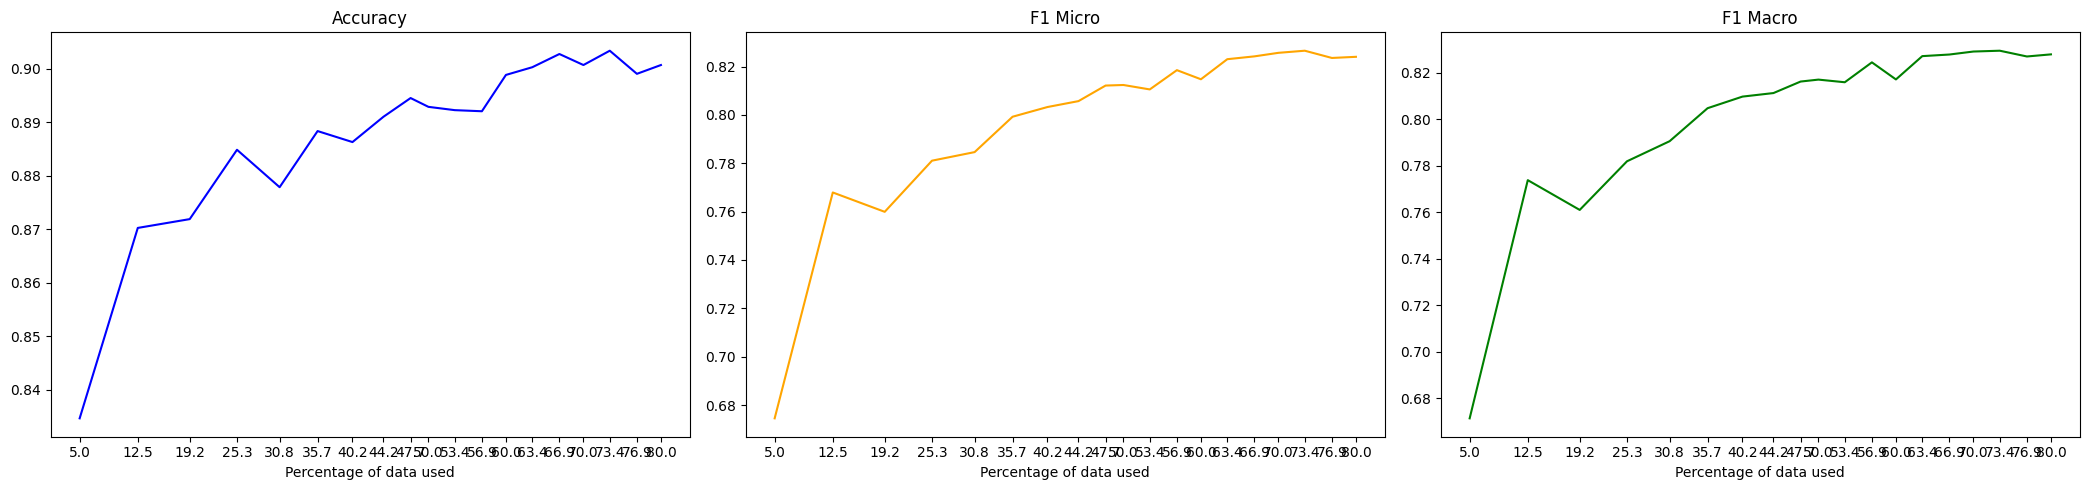

In [24]:
active_learning(42, 0, 'kmeans')

# CORESET

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4522, Accuracy: 0.7005, F1 Micro: 0.284, F1 Macro: 0.1444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2822, Accuracy: 0.7669, F1 Micro: 0.2904, F1 Macro: 0.2065
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.7924, F1 Micro: 0.5771, F1 Macro: 0.5558
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1846, Accuracy: 0.7981, F1 Micro: 0.6094, F1 Macro: 0.6
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.8051, F1 Micro: 0.6259, F1 Macro: 0.6206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1265, Accuracy: 0.8154, F1 Micro: 0.6408, F1 Macro: 0.637
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.8257, F1 Micro: 0.679, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.8341, F1 Micro: 0.6812, F1 Macro: 0.6787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0731

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5141, Accuracy: 0.7658, F1 Micro: 0.6085, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.8135, F1 Micro: 0.6362, F1 Macro: 0.6323
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2398, Accuracy: 0.8296, F1 Micro: 0.6768, F1 Macro: 0.6737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.8427, F1 Micro: 0.6856, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.8499, F1 Micro: 0.7059, F1 Macro: 0.7049
Epoch 6/10, Train Loss: 0.1485, Accuracy: 0.8355, F1 Micro: 0.6697, F1 Macro: 0.6565
Epoch 7/10, Train Loss: 0.1131, Accuracy: 0.8479, F1 Micro: 0.7009, F1 Macro: 0.6929
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.8493, F1 Micro: 0.6982, F1 Macro: 0.6903
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.8485, F1 Micro: 0.6868, F1 Macro: 0.6777
Epoch 10/10, Train Loss: 0.0587, Accuracy: 0.8542, F1 Micro: 0.703, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4463, Accuracy: 0.7362, F1 Micro: 0.6214, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2355, Accuracy: 0.8162, F1 Micro: 0.6732, F1 Macro: 0.6715
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.194, Accuracy: 0.8331, F1 Micro: 0.6818, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.8503, F1 Micro: 0.6994, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.8491, F1 Micro: 0.711, F1 Macro: 0.7056
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.8468, F1 Micro: 0.6815, F1 Macro: 0.6688
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.8413, F1 Micro: 0.6773, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.8518, F1 Micro: 0.7323, F1 Macro: 0.7337
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.8501, F1 Micro: 0.7004, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4613, Accuracy: 0.7769, F1 Micro: 0.6358, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2774, Accuracy: 0.8238, F1 Micro: 0.6472, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.8495, F1 Micro: 0.7102, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1828, Accuracy: 0.8623, F1 Micro: 0.7287, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.8561, F1 Micro: 0.7276, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.8653, F1 Micro: 0.7489, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.084, Accuracy: 0.867, F1 Micro: 0.752, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.8653, F1 Micro: 0.7364, F1 Macro: 0.7322
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.8664, F1 Micro: 0.7511, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4431, Accuracy: 0.7911, F1 Micro: 0.6535, F1 Macro: 0.6522
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.8538, F1 Micro: 0.7153, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.8694, F1 Micro: 0.7545, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1653, Accuracy: 0.8705, F1 Micro: 0.7656, F1 Macro: 0.7698
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.8771, F1 Micro: 0.7633, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.8779, F1 Micro: 0.7714, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.8756, F1 Micro: 0.7692, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.8717, F1 Micro: 0.7752, F1 Macro: 0.7809
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.8783, F1 Micro: 0.7751, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0354, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.457, Accuracy: 0.8004, F1 Micro: 0.6714, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2745, Accuracy: 0.8653, F1 Micro: 0.7484, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.8742, F1 Micro: 0.7538, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.8783, F1 Micro: 0.7709, F1 Macro: 0.7732
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.874, F1 Micro: 0.7565, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.8775, F1 Micro: 0.7741, F1 Macro: 0.7791
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.8779, F1 Micro: 0.7611, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.8834, F1 Micro: 0.7735, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.882, F1 Micro: 0.7765, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4339, Accuracy: 0.8357, F1 Micro: 0.6868, F1 Macro: 0.6856
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.8674, F1 Micro: 0.746, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.8752, F1 Micro: 0.7517, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1678, Accuracy: 0.881, F1 Micro: 0.7871, F1 Macro: 0.7943
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.8828, F1 Micro: 0.7826, F1 Macro: 0.7859
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.8814, F1 Micro: 0.7617, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.8801, F1 Micro: 0.7731, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.8845, F1 Micro: 0.7906, F1 Macro: 0.7944
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8871, F1 Micro: 0.7878, F1 Macro: 0.7894
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.8877, F1 Micro: 0.7897, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4358, Accuracy: 0.8454, F1 Micro: 0.7125, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2453, Accuracy: 0.8773, F1 Micro: 0.7665, F1 Macro: 0.7689
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.8742, F1 Micro: 0.7398, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1585, Accuracy: 0.89, F1 Micro: 0.7942, F1 Macro: 0.7978
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.8843, F1 Micro: 0.7931, F1 Macro: 0.7976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.8873, F1 Micro: 0.7963, F1 Macro: 0.801
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8875, F1 Micro: 0.7818, F1 Macro: 0.7824
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.8828, F1 Micro: 0.7844, F1 Macro: 0.787
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.8867, F1 Micro: 0.7943, F1 Macro: 0.7983
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8869, F1 Micro: 0.7912, F1 Macro: 0.7948

 Iteration 2768: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4326, Accuracy: 0.8417, F1 Micro: 0.7224, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.8729, F1 Micro: 0.7436, F1 Macro: 0.7413
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.8822, F1 Micro: 0.7792, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.8853, F1 Micro: 0.8045, F1 Macro: 0.8112
Epoch 5/10, Train Loss: 0.1288, Accuracy: 0.8884, F1 Micro: 0.802, F1 Macro: 0.807
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.8851, F1 Micro: 0.7822, F1 Macro: 0.7826
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.8785, F1 Micro: 0.7823, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.8836, F1 Micro: 0.7882, F1 Macro: 0.7915
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.8871, F1 Micro: 0.7964, F1 Macro: 0.7994
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.8834, F1 Micro: 0.791, F1 Macro: 0.7938

 Iteration 2899: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.8427, F1 Micro: 0.7261, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.8754, F1 Micro: 0.7485, F1 Macro: 0.7455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.8836, F1 Micro: 0.772, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.8869, F1 Micro: 0.7811, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1119, Accuracy: 0.8912, F1 Micro: 0.8039, F1 Macro: 0.8076
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.8882, F1 Micro: 0.7858, F1 Macro: 0.7863
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.8865, F1 Micro: 0.8013, F1 Macro: 0.8059
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.89, F1 Micro: 0.7881, F1 Macro: 0.7877
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.8873, F1 Micro: 0.7831, F1 Macro: 0.7838
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.8894, F1 Micro: 0.8013, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4387, Accuracy: 0.854, F1 Micro: 0.7273, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8777, F1 Micro: 0.7644, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.8855, F1 Micro: 0.7913, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.8933, F1 Micro: 0.8101, F1 Macro: 0.8138
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.8892, F1 Micro: 0.807, F1 Macro: 0.8109
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.8875, F1 Micro: 0.8012, F1 Macro: 0.8053
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.8917, F1 Micro: 0.7991, F1 Macro: 0.8014
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.8892, F1 Micro: 0.8044, F1 Macro: 0.8082
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8933, F1 Micro: 0.808, F1 Macro: 0.8106
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.8882, F1 Micro: 0.7994, F1 Macro: 0.8017

 Iteration 3299: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4145, Accuracy: 0.8518, F1 Micro: 0.7239, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8692, F1 Micro: 0.7365, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.8857, F1 Micro: 0.7855, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.8894, F1 Micro: 0.7902, F1 Macro: 0.792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.8933, F1 Micro: 0.797, F1 Macro: 0.7991
Epoch 6/10, Train Loss: 0.077, Accuracy: 0.8894, F1 Micro: 0.7968, F1 Macro: 0.7995
Epoch 7/10, Train Loss: 0.0572, Accuracy: 0.8894, F1 Micro: 0.7957, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.8927, F1 Micro: 0.7989, F1 Macro: 0.801
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.8904, F1 Micro: 0.7938, F1 Macro: 0.7964
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4239, Accuracy: 0.866, F1 Micro: 0.7551, F1 Macro: 0.759
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.8847, F1 Micro: 0.7983, F1 Macro: 0.8039
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.8894, F1 Micro: 0.8072, F1 Macro: 0.8122
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.8933, F1 Micro: 0.8128, F1 Macro: 0.8166
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.8923, F1 Micro: 0.8075, F1 Macro: 0.81
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.8925, F1 Micro: 0.8107, F1 Macro: 0.8147
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.897, F1 Micro: 0.8102, F1 Macro: 0.8133
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.8949, F1 Micro: 0.8098, F1 Macro: 0.8131
Epoch 9/10, Train Loss: 0.0323, Accuracy: 0.8939, F1 Micro: 0.8053, F1 Macro: 0.8075
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.8939, F1 Micro: 0.8032, F1 Macro: 0.8047

 Iteration 3678: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4122, Accuracy: 0.8721, F1 Micro: 0.7683, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.8863, F1 Micro: 0.801, F1 Macro: 0.8056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.8937, F1 Micro: 0.8041, F1 Macro: 0.8049
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.8929, F1 Micro: 0.8105, F1 Macro: 0.8154
Epoch 5/10, Train Loss: 0.1079, Accuracy: 0.8896, F1 Micro: 0.8068, F1 Macro: 0.8111
Epoch 6/10, Train Loss: 0.0748, Accuracy: 0.8925, F1 Micro: 0.8049, F1 Macro: 0.8096
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8904, F1 Micro: 0.8078, F1 Macro: 0.8119
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.8935, F1 Micro: 0.8026, F1 Macro: 0.8038
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.8919, F1 Micro: 0.8011, F1 Macro: 0.8036
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8912, F1 Micro: 0.7985, F1 Macro: 0.8007

 Iteration 3878: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8662, F1 Micro: 0.746, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.8904, F1 Micro: 0.7994, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.8964, F1 Micro: 0.8135, F1 Macro: 0.8172
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.8843, F1 Micro: 0.8032, F1 Macro: 0.8096
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.8945, F1 Micro: 0.8049, F1 Macro: 0.8061
Epoch 6/10, Train Loss: 0.0828, Accuracy: 0.898, F1 Micro: 0.8118, F1 Macro: 0.814
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.898, F1 Micro: 0.8167, F1 Macro: 0.8199
Epoch 8/10, Train Loss: 0.0491, Accuracy: 0.8925, F1 Micro: 0.7934, F1 Macro: 0.7948
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.8962, F1 Micro: 0.8098, F1 Macro: 0.8117
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.8951, F1 Micro: 0.8159, F1 Macro: 0.8205

 Iteration 4058: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4122, Accuracy: 0.8674, F1 Micro: 0.74, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.8861, F1 Micro: 0.8053, F1 Macro: 0.8116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.8931, F1 Micro: 0.8083, F1 Macro: 0.8121
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.8974, F1 Micro: 0.8074, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.8993, F1 Micro: 0.8225, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.9015, F1 Micro: 0.8234, F1 Macro: 0.8275
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9009, F1 Micro: 0.8207, F1 Macro: 0.8241
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.903, F1 Micro: 0.8215, F1 Macro: 0.8239
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.897, F1 Micro: 0.8084, F1 Macro: 0.8088
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.8991, F1 Micro: 0.8149, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.861, F1 Micro: 0.7152, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8929, F1 Micro: 0.8064, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.8966, F1 Micro: 0.8195, F1 Macro: 0.8246
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.8974, F1 Micro: 0.8202, F1 Macro: 0.8238
Epoch 5/10, Train Loss: 0.1021, Accuracy: 0.8997, F1 Micro: 0.8171, F1 Macro: 0.8201
Epoch 6/10, Train Loss: 0.0805, Accuracy: 0.8976, F1 Micro: 0.8198, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9007, F1 Micro: 0.8252, F1 Macro: 0.8289
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9003, F1 Micro: 0.8196, F1 Macro: 0.8228
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9005, F1 Micro: 0.821, F1 Macro: 0.8241
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.8999, F1 Micro: 0.8225, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8688, F1 Micro: 0.7739, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.8894, F1 Micro: 0.8018, F1 Macro: 0.8063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.897, F1 Micro: 0.817, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.9013, F1 Micro: 0.8217, F1 Macro: 0.8241
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.8972, F1 Micro: 0.812, F1 Macro: 0.8134
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.8974, F1 Micro: 0.8173, F1 Macro: 0.8208
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.8988, F1 Micro: 0.8174, F1 Macro: 0.8203
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9007, F1 Micro: 0.8239, F1 Macro: 0.8277
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9021, F1 Micro: 0.8219, F1 Macro: 0.8254
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.8984, F1 Micro: 0.8224, F1 Ma

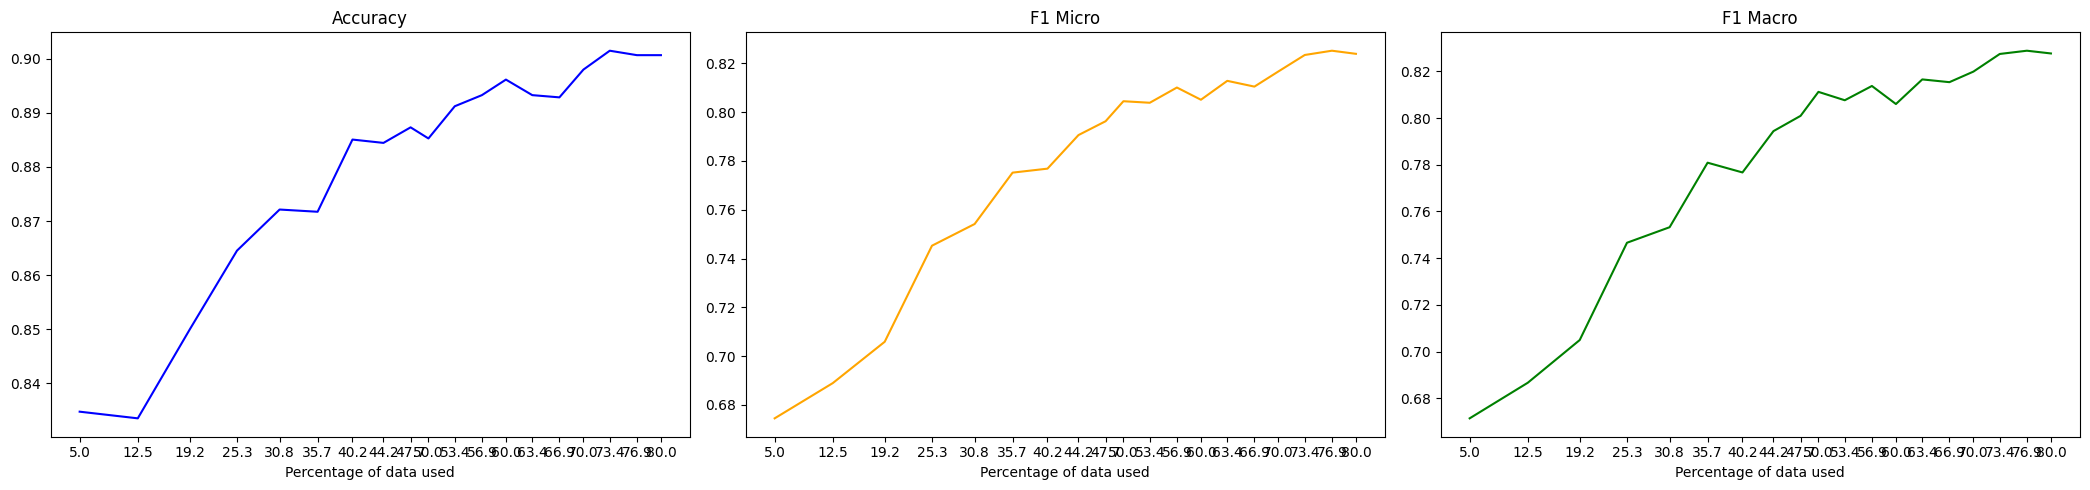

In [25]:
active_learning(42, 0, 'coreset')

# RANDOM SAMPLING

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6211, Accuracy: 0.7241, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5592, Accuracy: 0.7268, F1 Micro: 0.0192, F1 Macro: 0.0202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5179, Accuracy: 0.7553, F1 Micro: 0.2098, F1 Macro: 0.1721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4469, Accuracy: 0.7868, F1 Micro: 0.4416, F1 Macro: 0.3902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.413, Accuracy: 0.803, F1 Micro: 0.5838, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3666, Accuracy: 0.8047, F1 Micro: 0.6154, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3182, Accuracy: 0.815, F1 Micro: 0.642, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2846, Accuracy: 0.8226, F1 Micro: 0.6453, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2637, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5776, Accuracy: 0.7266, F1 Micro: 0.0177, F1 Macro: 0.0188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.8008, F1 Micro: 0.5491, F1 Macro: 0.5054
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3959, Accuracy: 0.8164, F1 Micro: 0.6318, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3197, Accuracy: 0.8444, F1 Micro: 0.7085, F1 Macro: 0.7075
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2722, Accuracy: 0.8604, F1 Micro: 0.7443, F1 Macro: 0.7476
Epoch 6/10, Train Loss: 0.2385, Accuracy: 0.8653, F1 Micro: 0.743, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1796, Accuracy: 0.8699, F1 Micro: 0.7542, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1392, Accuracy: 0.8715, F1 Micro: 0.7546, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.11, Accuracy: 0.8742, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5565, Accuracy: 0.7924, F1 Micro: 0.4842, F1 Macro: 0.4306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.8289, F1 Micro: 0.6556, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3056, Accuracy: 0.8544, F1 Micro: 0.735, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2521, Accuracy: 0.8655, F1 Micro: 0.758, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1881, Accuracy: 0.8657, F1 Micro: 0.7412, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1581, Accuracy: 0.8758, F1 Micro: 0.7695, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.8736, F1 Micro: 0.7699, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.8742, F1 Micro: 0.7727, F1 Macro: 0.7759
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.8746, F1 Micro: 0.7689, F1 Macro: 0.7711
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.7975, F1 Micro: 0.5496, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.8407, F1 Micro: 0.6759, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.8668, F1 Micro: 0.7649, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.8736, F1 Micro: 0.7784, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.8783, F1 Micro: 0.7804, F1 Macro: 0.7854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.8785, F1 Micro: 0.7817, F1 Macro: 0.7858
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.8816, F1 Micro: 0.783, F1 Macro: 0.7858
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.8783, F1 Micro: 0.7817, F1 Macro: 0.7852
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.8746, F1 Micro: 0.777, F1 Macro: 0.7804
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5247, Accuracy: 0.8047, F1 Micro: 0.5919, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3511, Accuracy: 0.8546, F1 Micro: 0.7115, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2594, Accuracy: 0.8723, F1 Micro: 0.7751, F1 Macro: 0.7801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1997, Accuracy: 0.8785, F1 Micro: 0.7856, F1 Macro: 0.7889
Epoch 5/10, Train Loss: 0.1588, Accuracy: 0.8783, F1 Micro: 0.7628, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.1354, Accuracy: 0.8808, F1 Micro: 0.785, F1 Macro: 0.7887
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.8783, F1 Micro: 0.7887, F1 Macro: 0.7942
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.8773, F1 Micro: 0.7869, F1 Macro: 0.7917
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.876, F1 Micro: 0.7808, F1 Macro: 0.7847
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.8791, F1 Micro: 0.7754, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8265, F1 Micro: 0.6515, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8682, F1 Micro: 0.7543, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2387, Accuracy: 0.8822, F1 Micro: 0.7858, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.8882, F1 Micro: 0.7975, F1 Macro: 0.8011
Epoch 5/10, Train Loss: 0.1571, Accuracy: 0.8824, F1 Micro: 0.784, F1 Macro: 0.7856
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.8851, F1 Micro: 0.7972, F1 Macro: 0.8013
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8867, F1 Micro: 0.7888, F1 Macro: 0.7913
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.8869, F1 Micro: 0.8026, F1 Macro: 0.8072
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8834, F1 Micro: 0.7884, F1 Macro: 0.792
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.8843, F1 Micro: 0.7983, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.8172, F1 Micro: 0.6465, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.8701, F1 Micro: 0.7371, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.237, Accuracy: 0.8791, F1 Micro: 0.793, F1 Macro: 0.7994
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.8863, F1 Micro: 0.7834, F1 Macro: 0.7832
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.8869, F1 Micro: 0.7894, F1 Macro: 0.7898
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.888, F1 Micro: 0.7958, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.8873, F1 Micro: 0.7985, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8867, F1 Micro: 0.8023, F1 Macro: 0.8064
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8882, F1 Micro: 0.7993, F1 Macro: 0.8021
Epoch 10/10, Train Loss: 0.0323, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.477, Accuracy: 0.8464, F1 Micro: 0.7042, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3002, Accuracy: 0.8738, F1 Micro: 0.768, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.8826, F1 Micro: 0.7911, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.8904, F1 Micro: 0.8072, F1 Macro: 0.8124
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.8904, F1 Micro: 0.805, F1 Macro: 0.8083
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.8875, F1 Micro: 0.8019, F1 Macro: 0.8056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.8925, F1 Micro: 0.8082, F1 Macro: 0.8107
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8939, F1 Micro: 0.8102, F1 Macro: 0.8132
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.8886, F1 Micro: 0.8071, F1 Macro: 0.8115
Epoch 10/10, Train Loss: 0.031, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4707, Accuracy: 0.8257, F1 Micro: 0.6204, F1 Macro: 0.5796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2869, Accuracy: 0.8771, F1 Micro: 0.7679, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2167, Accuracy: 0.8877, F1 Micro: 0.7908, F1 Macro: 0.7899
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.8896, F1 Micro: 0.8056, F1 Macro: 0.8104
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.8896, F1 Micro: 0.8009, F1 Macro: 0.8044
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.8906, F1 Micro: 0.7995, F1 Macro: 0.8021
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.8902, F1 Micro: 0.7954, F1 Macro: 0.796
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.8857, F1 Micro: 0.7899, F1 Macro: 0.7917
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.8892, F1 Micro: 0.8004, F1 Macro: 0.8026
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8851, F1 Micro: 0.8017, F1 Macro: 0.8064

 Iteration 2768: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.8429, F1 Micro: 0.7201, F1 Macro: 0.7243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2959, Accuracy: 0.881, F1 Micro: 0.7904, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.8824, F1 Micro: 0.7915, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.8929, F1 Micro: 0.8041, F1 Macro: 0.8059
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.8849, F1 Micro: 0.802, F1 Macro: 0.8055
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.8912, F1 Micro: 0.8034, F1 Macro: 0.8069
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8873, F1 Micro: 0.7981, F1 Macro: 0.8006
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.8855, F1 Micro: 0.799, F1 Macro: 0.8031
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.8912, F1 Micro: 0.8021, F1 Macro: 0.8041
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8908, F1 Micro: 0.8018, F1 Macro: 0.8045

 Iteration 2899: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8497, F1 Micro: 0.6896, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2779, Accuracy: 0.8797, F1 Micro: 0.7878, F1 Macro: 0.7937
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.8847, F1 Micro: 0.7997, F1 Macro: 0.8044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1699, Accuracy: 0.8929, F1 Micro: 0.8058, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.8933, F1 Micro: 0.8148, F1 Macro: 0.8208
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.8904, F1 Micro: 0.7988, F1 Macro: 0.8006
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8914, F1 Micro: 0.807, F1 Macro: 0.8118
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.8902, F1 Micro: 0.804, F1 Macro: 0.8061
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.8921, F1 Micro: 0.8039, F1 Macro: 0.8063
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.889, F1 Micro: 0.8105, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4401, Accuracy: 0.86, F1 Micro: 0.7448, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.8847, F1 Micro: 0.7815, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.8914, F1 Micro: 0.8014, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.8871, F1 Micro: 0.8043, F1 Macro: 0.8095
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.8929, F1 Micro: 0.8038, F1 Macro: 0.8066
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.8906, F1 Micro: 0.8006, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0675, Accuracy: 0.8941, F1 Micro: 0.8057, F1 Macro: 0.8092
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.8927, F1 Micro: 0.8041, F1 Macro: 0.8054
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8919, F1 Micro: 0.8108, F1 Macro: 0.8162
Epoch 10/10, Train Loss: 0.0303, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4465, Accuracy: 0.8454, F1 Micro: 0.6869, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2755, Accuracy: 0.884, F1 Micro: 0.7955, F1 Macro: 0.8007
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2073, Accuracy: 0.8896, F1 Micro: 0.8022, F1 Macro: 0.8045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.8939, F1 Micro: 0.8056, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.8951, F1 Micro: 0.8098, F1 Macro: 0.8128
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.8947, F1 Micro: 0.8134, F1 Macro: 0.8166
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.8945, F1 Micro: 0.8082, F1 Macro: 0.8097
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.8939, F1 Micro: 0.8104, F1 Macro: 0.8141
Epoch 9/10, Train Loss: 0.0342, Accuracy: 0.8931, F1 Micro: 0.8071, F1 Macro: 0.8089
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4426, Accuracy: 0.8649, F1 Micro: 0.7571, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2776, Accuracy: 0.8869, F1 Micro: 0.7863, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.891, F1 Micro: 0.8069, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.8988, F1 Micro: 0.8135, F1 Macro: 0.8165
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.8921, F1 Micro: 0.8014, F1 Macro: 0.8008
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.8939, F1 Micro: 0.8139, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.8974, F1 Micro: 0.8139, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.044, Accuracy: 0.8993, F1 Micro: 0.8219, F1 Macro: 0.8258
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.896, F1 Micro: 0.8109, F1 Macro: 0.8113
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8701, F1 Micro: 0.7666, F1 Macro: 0.7706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2581, Accuracy: 0.8888, F1 Micro: 0.793, F1 Macro: 0.793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.8937, F1 Micro: 0.81, F1 Macro: 0.8123
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.898, F1 Micro: 0.8158, F1 Macro: 0.8181
Epoch 5/10, Train Loss: 0.1205, Accuracy: 0.8917, F1 Micro: 0.8073, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.8968, F1 Micro: 0.8171, F1 Macro: 0.8203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0602, Accuracy: 0.8958, F1 Micro: 0.8195, F1 Macro: 0.8235
Epoch 8/10, Train Loss: 0.0416, Accuracy: 0.8943, F1 Micro: 0.8112, F1 Macro: 0.8149
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.8964, F1 Micro: 0.8142, F1 Macro: 0.8177
Epoch 10/10, Train Loss: 0.0273, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8637, F1 Micro: 0.7602, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8836, F1 Micro: 0.7916, F1 Macro: 0.7941
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2125, Accuracy: 0.89, F1 Micro: 0.8062, F1 Macro: 0.8109
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.8947, F1 Micro: 0.8179, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.8997, F1 Micro: 0.8195, F1 Macro: 0.8226
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.898, F1 Micro: 0.8133, F1 Macro: 0.814
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.897, F1 Micro: 0.8183, F1 Macro: 0.8228
Epoch 8/10, Train Loss: 0.0433, Accuracy: 0.8949, F1 Micro: 0.819, F1 Macro: 0.8231
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.034, Accuracy: 0.8995, F1 Micro: 0.8203, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4175, Accuracy: 0.8723, F1 Micro: 0.7724, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.8888, F1 Micro: 0.7939, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.8956, F1 Micro: 0.8104, F1 Macro: 0.8141
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.8947, F1 Micro: 0.8145, F1 Macro: 0.8196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.8997, F1 Micro: 0.8179, F1 Macro: 0.8221
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.8984, F1 Micro: 0.8153, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9017, F1 Micro: 0.8257, F1 Macro: 0.8286
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9028, F1 Micro: 0.8242, F1 Macro: 0.8259
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9015, F1 Micro: 0.8192, F1 Macro: 0.8217
Epoch 10/10, Train Loss: 0.0273, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.8699, F1 Micro: 0.7328, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.8931, F1 Micro: 0.7995, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.8962, F1 Micro: 0.8172, F1 Macro: 0.8215
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.8982, F1 Micro: 0.8126, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1129, Accuracy: 0.9001, F1 Micro: 0.8224, F1 Macro: 0.8256
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.8978, F1 Micro: 0.8181, F1 Macro: 0.8199
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.8993, F1 Micro: 0.8133, F1 Macro: 0.8164
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9023, F1 Micro: 0.8224, F1 Macro: 0.8248
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.8999, F1 Micro: 0.8186, F1 Macro: 0.8211
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.8984, F1 Micro: 0.8113, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8715, F1 Micro: 0.7567, F1 Macro: 0.7596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.8855, F1 Micro: 0.8072, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8991, F1 Micro: 0.8135, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.8976, F1 Micro: 0.8181, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.897, F1 Micro: 0.8224, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0767, Accuracy: 0.9015, F1 Micro: 0.8269, F1 Macro: 0.8299
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.8962, F1 Micro: 0.8159, F1 Macro: 0.8183
Epoch 8/10, Train Loss: 0.0469, Accuracy: 0.897, F1 Micro: 0.8214, F1 Macro: 0.8264
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.8974, F1 Micro: 0.8241, F1 Macro: 0.8291
Epoch 10/10, Train Loss: 0.0263, Accurac

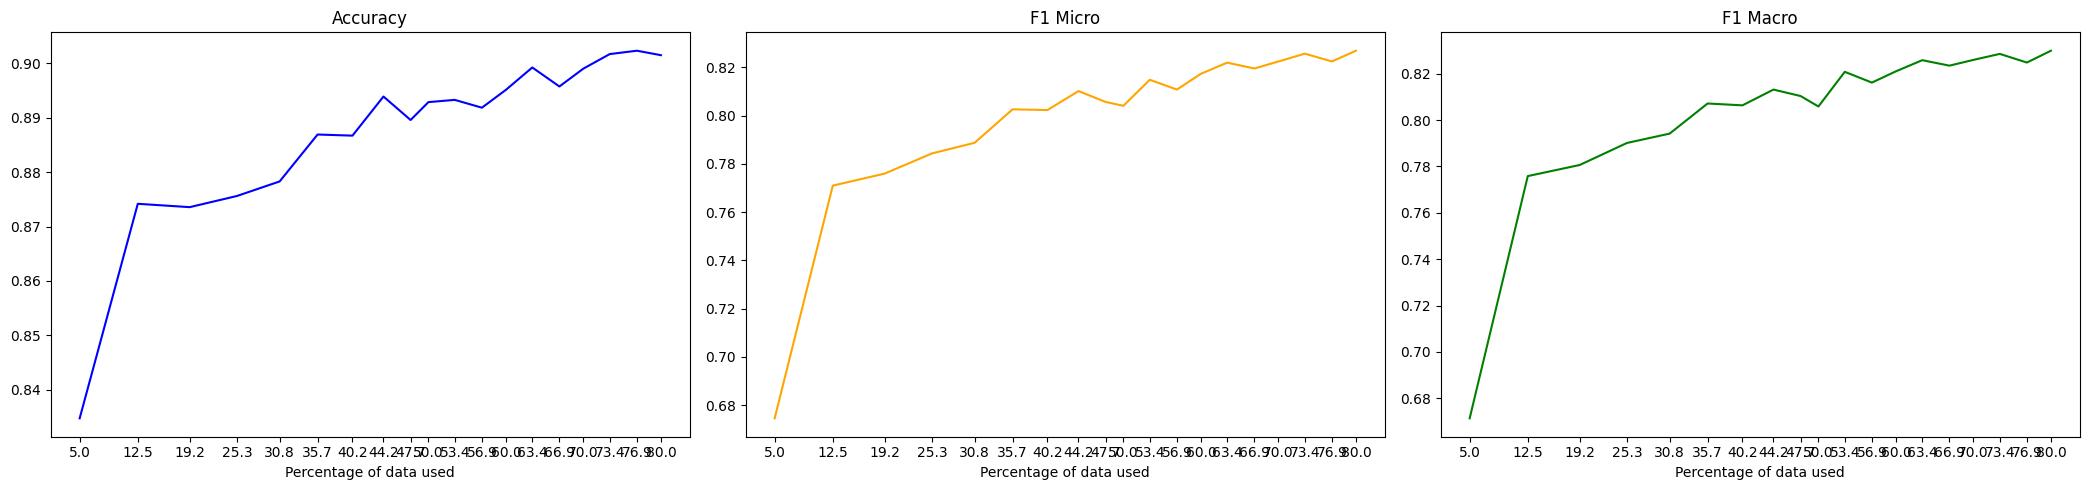

In [26]:
active_learning(42, 0, 'random')